# Synthetic dataset

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from GeoConformalizedExplainer import GeoConformalizedExplainer
import matplotlib.pyplot as plt
import shap

C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams['legend.fontsize'] = 16

def plot_contribution(b, k=3, size=50, title=None, sub_titles=None, non_spatial=None, vmin=None, vmax=None, interpolation=None):
    fig, axes = plt.subplots(1, k, figsize=(6 * k, 5), dpi=500)

    for i in range(k):
        ax = axes[i]
        if i in non_spatial:
            ax.scatter(b[i][0], b[i][1], s=5, color='black')
            ax.set_ylim(b[i][2], b[i][3])
            ax.set_xlim(-2.5, 2.5)
            ax.set_xlabel(r'$X_{}$'.format(i),fontsize=16)
            ax.xaxis.set_tick_params(labelsize=20)
            ax.yaxis.set_tick_params(labelsize=20)
        else:
            c = ax.imshow(b[i].reshape(size, size), cmap=plt.get_cmap('viridis', 36), vmin=vmin, vmax=vmax, interpolation=interpolation)
            cb = fig.colorbar(c, ax=ax)
            cb.ax.tick_params(labelsize=20)
            ax.set_xticks(np.arange(-0.5, size, 5))
            ax.set_yticks(np.arange(-0.5, size, 5))
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.tick_params(axis='x', colors=(0,0,0,0))
            ax.tick_params(axis='y', colors=(0,0,0,0))
        ax.set_title(sub_titles[i], fontsize=20, y=1.05)

    plt.savefig(f'{title}.png', bbox_inches='tight')

## Data generation

In [3]:
size = 50

b0 = np.ones((size, size))
b1 = np.ones((size, size))
b2 = np.ones((size, size))
b4 = np.ones((size, size))
noise = np.ones((size, size))

for i in range(size):
    for j in range(size):
        b0[i, j] = 6 * np.exp(-((i - 25)**2 + (j - 25)**2) / (2 * 15**2))
        b1[i, j] = i / 49 * 6
        b2[i, j] = (i + j) / 49 * 3
        # b4[i, j] = 6 * np.exp(-((i - 10)**2 + (j - 10)**2) / (2 * 8**2)) + 6 * np.exp(-((i - 40)**2 + (j - 40)**2) / (2 * 15**2))
        noise[i, j] = 2 * np.exp(-((i - 10)**2 + (j - 10)**2) / (2 * 8**2)) + 2 * np.exp(-((i - 40)**2 + (j - 40)**2) / (2 * 15**2))

# b3 = np.flip(b2, axis=1).T
b3 = np.ones(size*size).reshape(-1)*2


In [4]:
b0 = b0.reshape(-1)
b1 = b1.reshape(-1)
b2 = b2.reshape(-1)
b3 = b3.reshape(-1)
b4 = b4.reshape(-1)
noise = noise.reshape(-1)

In [5]:
np.random.seed(222)

X1 = np.random.uniform(-2, 2, size*size)
X2 = np.random.uniform(-2, 2, size*size)
X3 = np.random.uniform(-2, 2, size*size)
X4 = np.random.uniform(-2, 2, size*size)

X = np.vstack([X1, X2, X3, X4]).T
u = np.array([np.linspace(0,size - 1,num=size)]*size).reshape(-1)
v = np.array([np.linspace(0,size - 1,num=size)]*size).T.reshape(-1)
coords = np.array(list(zip(u,v)))

k = X.shape[1]
n = X.shape[0]

In [6]:
X_coords = pd.DataFrame(np.concatenate((X, np.array(coords)), axis=1), columns=['X1', 'X2', 'X3', 'X4', 'x_coord', 'y_coord'])

In [7]:
X_coords

,X1,X2,X3,X4,x_coord,y_coord
0,0.104114,0.964917,1.011381,1.192011,0.0,0.0
1,0.741269,-0.440030,-0.936705,1.024414,1.0,0.0
2,1.342697,-0.875739,-1.148677,-1.992029,2.0,0.0
3,0.615061,1.082512,-1.266801,-0.424231,3.0,0.0
4,-1.851912,0.026923,-0.659943,1.062233,4.0,0.0
...,...,...,...,...,...,...
2495,-1.798074,-0.779403,0.012337,-1.363451,45.0,49.0
2496,0.239688,-0.666447,0.497581,0.348732,46.0,49.0
2497,-1.719665,-1.038000,-0.700350,1.508266,47.0,49.0
2498,-0.650496,-1.045958,0.776005,1.999300,48.0,49.0


In [8]:
X_coords = X_coords - X_coords.mean(axis=0)

In [9]:
# f0 = b0
f1 = b1 * X_coords.values[:, 0]
f2 = b2 * X_coords.values[:, 1]
f3 = b3 * X_coords.values[:, 2]
f4 = X_coords.values[:, 3] ** 2

In [10]:
y = pd.DataFrame(f1 + f2 + f3 + f4 + noise, columns=['y'])

In [11]:
b = [b1, b2, [X_coords.values[:,2], f3, -6, 6], [X_coords.values[:,3], f4, -1, 5], noise]

In [12]:
sub_titles = [r'$\beta_1(u,v)$', r'$\beta_2(u,v)$', r'$f_{3}(X_{3})$', r'$f_{4}(X_{4})$', 'noise']

0
1
2
3
4


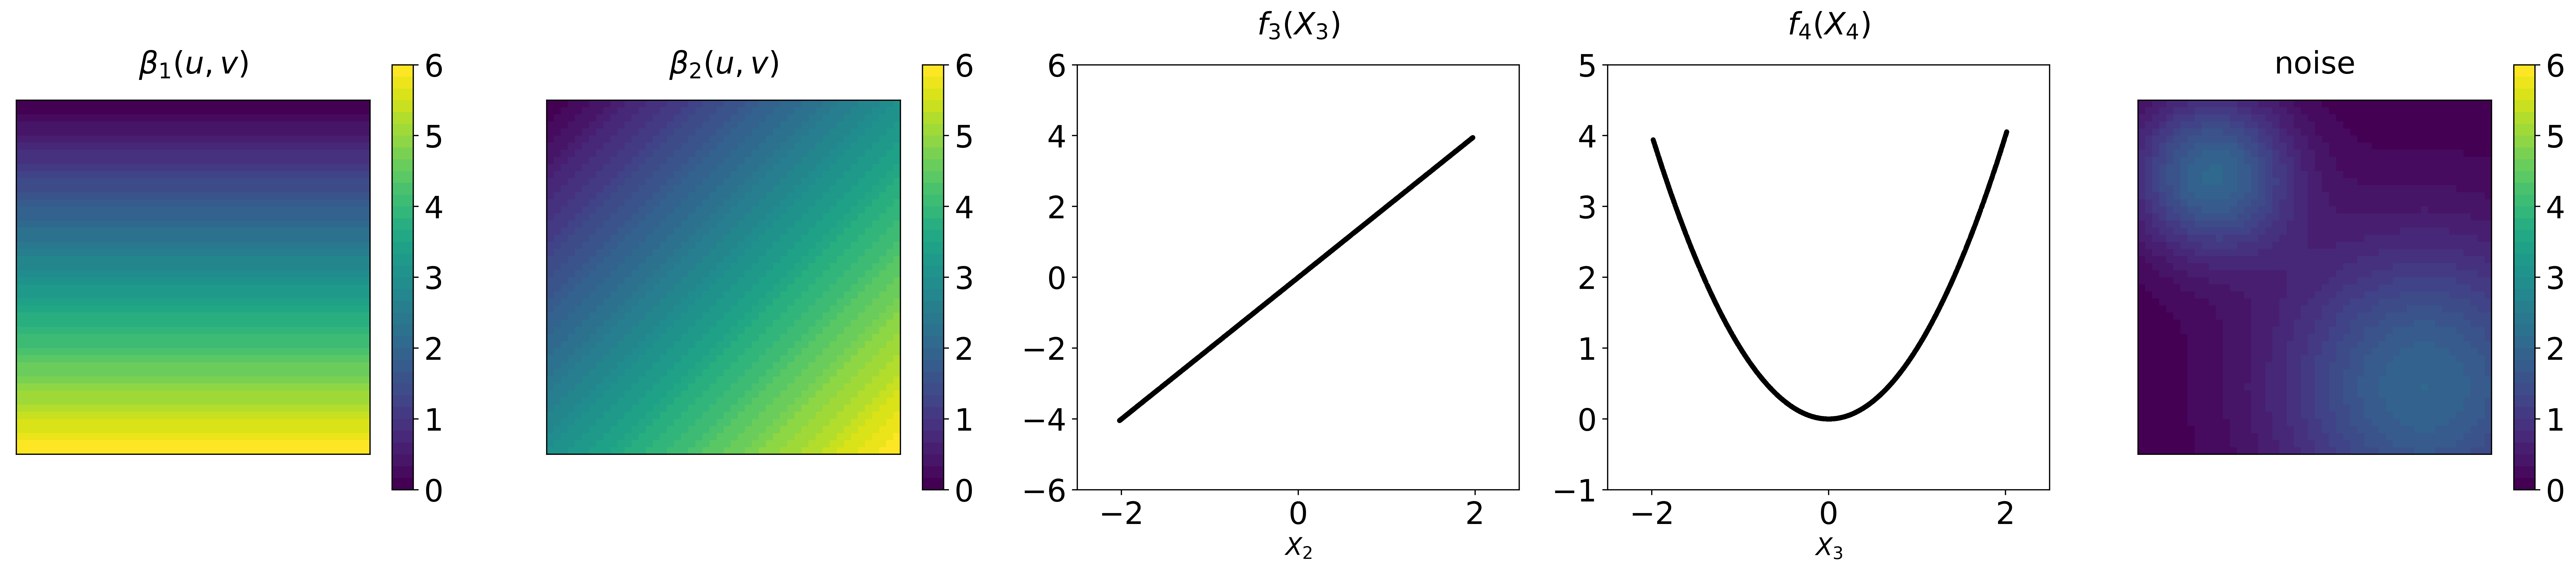

In [13]:
plot_contribution(b=b, k=5, sub_titles=sub_titles, vmin=0, vmax=6, title='Synthetic data validation', non_spatial=[2, 3])

In [14]:
class Model:
    def __init__(self, f):
        self.predict = f

In [15]:
def predict(X_coords):
    try:
        X_coords = X_coords.values
    except:
        pass
    n, k = X_coords.shape
    y_pred = []

    for i in range(n):
        u = X_coords[i, -1]
        v = X_coords[i, -2]
        # f0 = 6 * np.exp(-((u - 25)**2 + (v - 25)**2) / (2 * 15**2))
        f1 = u / 49 * 6 * X_coords[i,0]
        f2 = (u + v) / 49 * 3 * X_coords[i,1]
        f3 = 2 * X_coords[i, 2]
        f4 = X_coords[i, 3]**2
        noise = 2 * np.exp(-((i - 10)**2 + (j - 10)**2) / (2 * 8**2)) + 2 * np.exp(-((i - 40)**2 + (j - 40)**2) / (2 * 15**2))

        # y = f0 + f1 + f2 + f3 + f4
        y = f1 + f2 + f3 + f4 + noise
        y_pred.append(y)
    return np.array(y_pred)

In [16]:
true_model = Model(predict)

In [17]:
loc = X_coords[['x_coord', 'y_coord']]

In [18]:
X_train, X_temp, loc_train, loc_temp = train_test_split(X_coords, loc, train_size=0.8, random_state=42)

In [19]:
X_calib, X_test, loc_calib, loc_test = train_test_split(X_temp, loc_temp, train_size=0.5, random_state=42)

In [20]:
X_train, X_calib, loc_train, loc_calib = train_test_split(X_coords, loc, train_size=0.8, random_state=42)

In [21]:
explainer = GeoConformalizedExplainer(true_model, X_train, X_calib, loc_calib.values, loc.values, 0.1, 15)

In [22]:
results = explainer.uncertainty_aware_explain(x_test=X_coords)

PermutationExplainer explainer: 2001it [10:05,  3.27it/s]                          
PermutationExplainer explainer: 501it [02:28,  3.13it/s]                         
PermutationExplainer explainer: 2501it [12:40,  3.24it/s]                          
100%|██████████| 6/6 [00:00<00:00, 128.04it/s]


In [23]:
results.accuracy_summary()

,coverage_probability,R2,RMSE,SHAP_Var,Pred_SHAP_Var
X1,0.8172,0.947816,0.239740,1.101403,1.025031
X2,0.9868,0.941309,0.176257,0.529318,0.495375
X3,0.0000,0.984720,0.285291,5.326734,5.321795
X4,0.6372,0.989106,0.125707,1.450518,1.450776
x_coord,0.9980,0.935545,0.129342,0.259553,0.255514
y_coord,0.9676,0.936263,0.299977,1.411825,1.342682


In [24]:
pred_results = results.result

In [25]:
pred_results

,X1_shap,X2_shap,X3_shap,X4_shap,x_coord_shap,y_coord_shap,X1_value,X2_value,X3_value,X4_value,...,x_coord_coverage_probability,x_coord_pred,y_coord_geo_uncertainty,y_coord_uncertainty,y_coord_upper_bound,y_coord_lower_bound,y_coord_coverage_probability,y_coord_pred,x,y
0,-0.560778,-1.509878,2.046893,-0.033892,-0.778155,-0.975312,0.146524,0.958971,0.986097,1.205967,...,0.998,-0.777780,0.623955,0.610959,-0.516466,-1.764376,0.9676,-1.140421,-24.5,-24.5
1,-1.443176,0.394539,-1.849900,-0.393565,0.317782,-0.833044,0.783679,-0.445976,-0.961988,1.038370,...,0.998,0.243136,0.623955,0.610959,-0.392111,-1.640020,0.9676,-1.016065,-23.5,-24.5
2,-2.221536,0.977272,-2.281800,2.440387,0.612400,-1.501285,1.385107,-0.881685,-1.173960,-1.978073,...,0.998,0.577851,0.623955,0.610959,-1.048290,-2.296200,0.9676,-1.672245,-22.5,-24.5
3,-1.268810,-1.567721,-2.493135,-1.287381,-0.784675,-1.939684,0.657471,1.076566,-1.292084,-0.410275,...,0.998,-0.809140,0.623955,0.610959,-1.418430,-2.666339,0.9676,-2.042385,-21.5,-24.5
4,1.999025,-0.216599,-1.287830,-0.297390,-0.047809,3.087859,-1.809502,0.020977,-0.685226,1.076189,...,0.998,-0.063404,0.623955,0.610959,3.412529,2.164620,0.9676,2.788574,-20.5,-24.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,-2.849285,-1.225657,0.072664,0.339629,-0.604790,-3.289213,-1.755664,-0.785349,-0.012946,-1.349496,...,0.998,-0.382989,0.651102,0.610959,-2.335616,-3.637819,0.9676,-2.986717,20.5,24.5
2496,0.596603,-1.091110,1.002685,-1.315777,-0.539669,-0.545166,0.282098,-0.672393,0.472298,0.362688,...,0.998,-0.363696,0.651102,0.610959,0.612980,-0.689223,0.9676,-0.038122,21.5,24.5
2497,-2.725417,-1.701606,-1.361022,0.861450,-0.793042,-3.371434,-1.677256,-1.043946,-0.725634,1.522222,...,0.998,-0.452142,0.651102,0.610959,-2.674829,-3.977033,0.9676,-3.325931,22.5,24.5
2498,-0.930815,-1.736378,1.575847,2.589366,-0.840378,-1.939755,-0.608086,-1.051904,0.750722,2.013256,...,0.998,-0.446749,0.651576,0.610959,-0.324555,-1.627707,0.9676,-0.976131,23.5,24.5


In [26]:
b = pred_results[['X1_pred', 'X2_pred', 'X3_pred', 'X4_pred']]

In [27]:
pred_b = [b['X1_pred'].values, b['X2_pred'].values, [X_coords.values[:,2], b['X3_pred'].values, -6, 6], [X_coords.values[:,3], b['X4_pred'].values, -1, 5]]

In [28]:
sub_titles = [r'$\beta_1(u,v)$', r'$\beta_2(u,v)$', r'$f_{3}(X_{3})$', r'$f_{4}(X_{4})$']

0
1
2
3


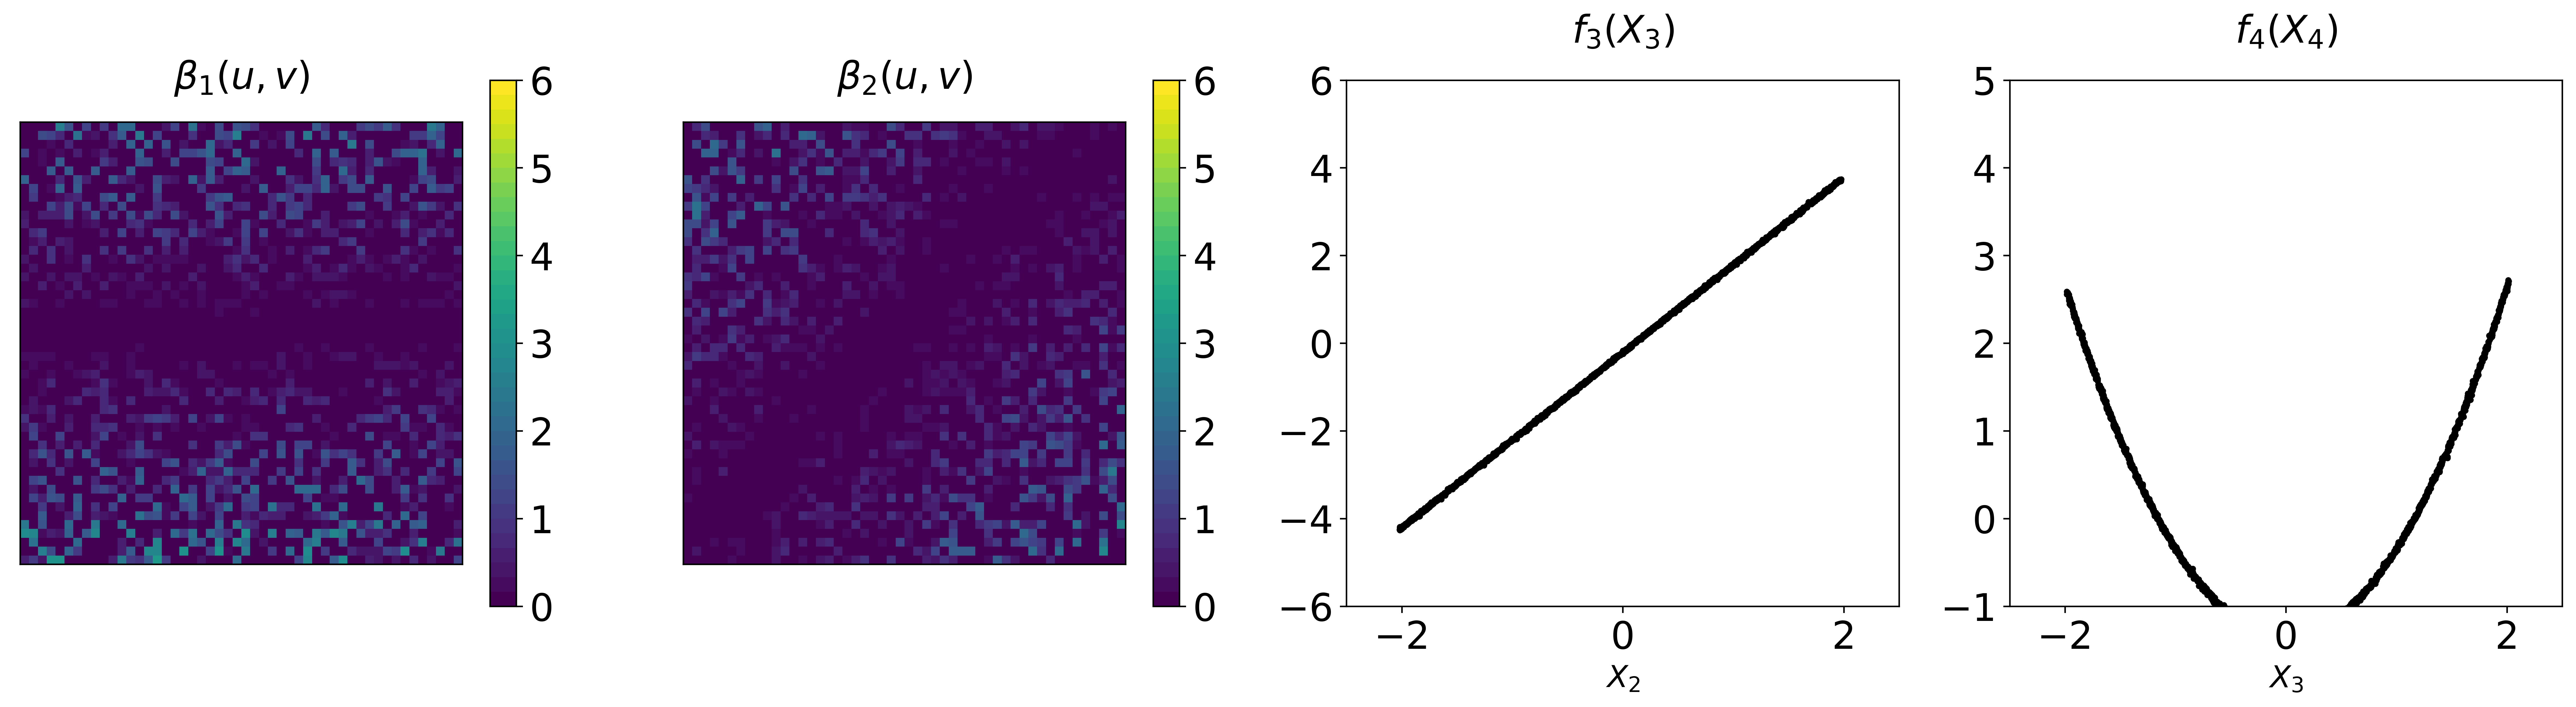

In [29]:
plot_contribution(pred_b, k=4, sub_titles=sub_titles, vmin=0, vmax=6, title='Synthetic data validation - ConformalSHAP', non_spatial=[2, 3])